In [1]:
import sklearn
import os
from tqdm.autonotebook import tqdm
import numpy as np
from PIL import Image
import pandas as pd
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, load_model, Model 
from keras.layers import Conv2D, MaxPool2D, Add, Dense, Reshape, Flatten, Dropout, BatchNormalization, ReLU, Activation, Concatenate, Flatten, Input, Concatenate, Activation, LSTM, Bidirectional, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from keras import Input
from keras import backend
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# check GPU
!nvidia-smi

Mon Aug  1 16:32:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip "/content/gdrive/MyDrive/AI Draw Equation/AIDE dataset.zip" -d "/content"

In [4]:
# Load train and val dataset
list_categories = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "add", "dec", "div", "mul", "stroke", "sub", "(", ")"]
train_path = "/content/AIDE dataset/train"
X_train = []
Y_train = []
for label_folder in os.listdir(train_path):
  curr_path = os.path.join(train_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_train.append(img)
    Y_train.append(int(lbl))
X_train = np.array(X_train) / 255.0
Y_train = np.array(Y_train)

val_path = "/content/AIDE dataset/val"
X_val = []
Y_val = []
for label_folder in os.listdir(val_path):
  curr_path = os.path.join(val_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_val.append(img)
    Y_val.append(int(lbl))
X_val = np.array(X_val) / 255.0
Y_val = np.array(Y_val)

Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

In [5]:
print(f"Number of train samples: {X_train.shape[0]}")
print(f"Number of val samples: {X_val.shape[0]}")

Number of train samples: 11394
Number of val samples: 3806


In [7]:
from tensorflow.keras.applications import VGG19

input_img = Input(shape=(112, 112 , 1), name="input")
x = Concatenate()([input_img, input_img, input_img])
model_vgg19 = VGG19(weights='imagenet',input_tensor = x, include_top=False)
x = model_vgg19.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
output = Dense(18, activation='softmax')(x)
model = Model(inputs = input_img, outputs = output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 112, 112, 3)  0           ['input[0][0]',                  
                                                                  'input[0][0]',                  
                                                                  'input[0][0]']                  
                                                                                                  
 block1_conv1 (Conv2D)          (None, 112, 112, 64  1792        ['concatenate_1[0][0]']    

In [9]:
lr = 0.001
opt = keras.optimizers.Adam(learning_rate = lr)
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
train = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 50, batch_size = 32, verbose = 1)  

Epoch 1/5
357/357 [==============================] - 65s 173ms/step - loss: 1.3206 - accuracy: 0.5784 - val_loss: 0.7601 - val_accuracy: 0.7688
Epoch 2/5
357/357 [==============================] - 57s 160ms/step - loss: 0.4163 - accuracy: 0.8660 - val_loss: 0.3111 - val_accuracy: 0.8996
Epoch 3/5
357/357 [==============================] - 57s 159ms/step - loss: 0.2522 - accuracy: 0.9199 - val_loss: 0.1805 - val_accuracy: 0.9496
Epoch 4/5
357/357 [==============================] - 57s 159ms/step - loss: 0.1866 - accuracy: 0.9421 - val_loss: 0.1627 - val_accuracy: 0.9493
Epoch 5/5
357/357 [==============================] - 57s 159ms/step - loss: 0.1438 - accuracy: 0.9526 - val_loss: 0.1900 - val_accuracy: 0.9480


In [10]:
# Load test 
test_path = "/content/AIDE dataset/test"
X_test = []
Y_test = []
for label_folder in os.listdir(test_path):
  curr_path = os.path.join(test_path, label_folder)
  lbl = list_categories.index(label_folder)
  for img_name in os.listdir(curr_path):
    img = cv2.imread(os.path.join(curr_path, img_name), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, None, fx = 0.5, fy = 0.5)
    X_test.append(img)
    Y_test.append(int(lbl))
X_test = np.array(X_test) / 255.0
Y_test = np.array(Y_test)

Y_test = to_categorical(Y_test)

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Loss = ", test_loss)
print("Evaluation Accuracy = ", test_accuracy * 100)

Loss =  0.1779029816389084
Evaluation Accuracy =  94.37877535820007


In [ ]:
count = 0
for i in range(X_test.shape[0]):
  pred = model.predict(X_test[i].reshape(1, 112, 112, 1))
  pred = list_categories[np.argmax(pred)]
  true = list_categories[np.argmax(Y_test[i])]
  if pred == true:
    count += 1
print(f"Test Accuracy: {count / X_test.shape[0]}")

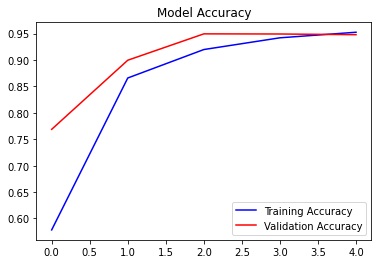

In [12]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

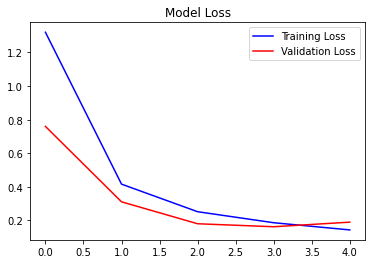

In [13]:
train_loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [ ]:
model_json = model.to_json()
with open(f"/content/gdrive/MyDrive/AI Draw Equation/Model/VGG19 lr={lr}.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(f"/content/gdrive/MyDrive/AI Draw Equation/Model/VGG19 lr={lr}.h5")